# Group Component 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                            roc_curve, auc, precision_recall_curve, average_precision_score,
                            f1_score, matthews_corrcoef, balanced_accuracy_score, make_scorer, roc_auc_score)
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import warnings
import time
import shap
from sklearn.inspection import permutation_importance
from sklearn.calibration import CalibrationDisplay
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced


# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
df = pd.read_csv('cleaned_diabetes_data.csv')

# Data Preprocessing
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())

Dataset Shape: (98991, 38)

Missing Values:
 Cholesterol Check                     0
Body Mass Index (BMI)                 0
BMI Classes                           0
Smoking Status                        0
Stroke                                0
History of Heart Disease or Attack    0
Days with Mental Health Issues        0
Days with Physical Health Issues      0
Difficulty Walking                    0
Gender                                0
Age                                   0
Age Group Classes                     0
General Health Classes                0
Education Level                       0
Income                                0
Income Classes                        0
BloodPressure                         0
Cholesterol                           0
Alcoholic                             0
NewBMI_Underweight                    0
NewBMI_Normal                         0
NewBMI_Overweight                     0
NewBMI_Obesity 1                      0
NewBMI_Obesity 2                   

In [3]:
df.head()

Cholesterol Check  Body Mass Index (BMI) BMI Classes  Smoking Status  \
0                1.0                  25.00  Overweight             0.0   
1                1.0                  28.78  Overweight             1.0   
2                1.0                  30.00   Obesity 1             0.0   
3                1.0                  28.53  Overweight             0.0   
4                1.0                  24.00      Normal             0.0   

   Stroke  History of Heart Disease or Attack  Days with Mental Health Issues  \
0     0.0                                 0.0                             0.0   
1     0.0                                 0.0                             0.0   
2     0.0                                 0.0                             0.0   
3     0.0                                 1.0                            30.0   
4     0.0                                 0.0                             0.0   

   Days with Physical Health Issues  Difficulty Walking         Gender  ...  \
0                               0.0                 0.0         Female  ...   
1                               0.0                 0.0           Male  ...   
2                               0.0                 0.0         Female  ...   
3                              30.0                 0.0  Not specified  ...   
4                               0.0                 0.0           Male  ...   

   GeneralHealth_Very Good GeneralHealth_Excellent Age Group: Child (0-12)  \
0                        0                       0                       0   
1                        1                       0                       0   
2                        0                       0                       0   
3                        0                       0                       0   
4                        1                       0                       0   

  Age Group: Teen (12-18)  Age Group: Young Adult (18-35)  \
0                       0                               0   
1                       0                               0   
2                       0                               0   
3                       0                               0   
4                       0                               0   

  Age Group: Adult (35-50)  Age Group: Middle-Aged (50-65)  \
0                        0                               1   
1                        0                               0   
2                        0                               1   
3                        0                               1   
4                        0                               1   

   Age Group: Senior (65-80)  Age Group: Elderly (80+)  Diabetes Status  
0                          0                         0               No  
1                          1                         0               No  
2                          0                         0               No  
3                          0                         0         Diabetes  
4                          0                         0               No  

[5 rows x 38 columns]

In [4]:
# Count the unique values in the 'Gender' column
gender_counts = df['Gender'].value_counts()

print(gender_counts)


Gender
Female           45853
Male             35903
Not specified    17235
Name: count, dtype: int64


In [5]:
# Remove rows where 'Gender' is 'Not specified'
df = df[df['Gender'] != 'Not specified']

# Check the shape of the cleaned dataset
print("Cleaned Dataset Shape:", df.shape)

Cleaned Dataset Shape: (81756, 38)


In [6]:
df = pd.get_dummies(df, columns=['Gender', 'Income Classes'], drop_first=False)

# Convert all boolean columns to integers (0/1)
df = df.astype({col: 'int' for col in df.select_dtypes('bool').columns})

In [7]:
# Remove redundant original categorical columns (keep one-hot encoded versions)
cols_to_drop = [
    'BMI Classes',
    'Body Mass Index (BMI)',
    'Age Group Classes',
    'General Health Classes',
    'Income',
    'Education Level',
    'Days with Physical Health Issues',
    'Days with Mental Health Issues',
    'Age Group: Child (0-12)',#As only 0 is present in these 2 columns
    'Age Group: Teen (12-18)',
    'Cholesterol Check'
]

df = df.drop(cols_to_drop, axis=1)

# Keep either continuous variables OR one-hot encoded versions (choose one):
df = df.drop(['Age'], axis=1)  # Keep one-hot age groups

In [8]:
# Convert 'Diabetes Status' column to binary (0 for 'No', 1 for 'Diabetes' and 'Prediabetes')
df['Diabetes Status'] = df['Diabetes Status'].replace({'No': 0, 'Diabetes': 1, 'Prediabetes': 1})

# Verify the change
print(df['Diabetes Status'].unique())

[0 1]


In [9]:
# Convert all columns with 0 and 1 values to integers
cols_to_convert = df.select_dtypes(include=['float64']).columns

# Convert to int
df[cols_to_convert] = df[cols_to_convert].astype('int')

# Verify the change
print(df.dtypes)

Smoking Status                        int32
Stroke                                int32
History of Heart Disease or Attack    int32
Difficulty Walking                    int32
BloodPressure                         int64
Cholesterol                           int64
Alcoholic                             int64
NewBMI_Underweight                    int64
NewBMI_Normal                         int64
NewBMI_Overweight                     int64
NewBMI_Obesity 1                      int64
NewBMI_Obesity 2                      int64
NewBMI_Obesity 3                      int64
GeneralHealth_Poor                    int64
GeneralHealth_Fair                    int64
GeneralHealth_Good                    int64
GeneralHealth_Very Good               int64
GeneralHealth_Excellent               int64
Age Group: Young Adult (18-35)        int64
Age Group: Adult (35-50)              int64
Age Group: Middle-Aged (50-65)        int64
Age Group: Senior (65-80)             int64
Age Group: Elderly (80+)        

In [10]:
# Get unique values for each column
unique_values = {col: df[col].unique().tolist() for col in df.columns}

# Print the unique values
for column, values in unique_values.items():
    print(f"Unique values in '{column}':")
    print(values)
    print('-' * 50)

Unique values in 'Smoking Status':
[0, 1]
--------------------------------------------------
Unique values in 'Stroke':
[0, 1]
--------------------------------------------------
Unique values in 'History of Heart Disease or Attack':
[0, 1]
--------------------------------------------------
Unique values in 'Difficulty Walking':
[0, 1]
--------------------------------------------------
Unique values in 'BloodPressure':
[0, 1]
--------------------------------------------------
Unique values in 'Cholesterol':
[0, 1]
--------------------------------------------------
Unique values in 'Alcoholic':
[0, 1]
--------------------------------------------------
Unique values in 'NewBMI_Underweight':
[0, 1]
--------------------------------------------------
Unique values in 'NewBMI_Normal':
[0, 1]
--------------------------------------------------
Unique values in 'NewBMI_Overweight':
[1, 0]
--------------------------------------------------
Unique values in 'NewBMI_Obesity 1':
[0, 1]
-------------

In [11]:
df.head()

Smoking Status  Stroke  History of Heart Disease or Attack  \
0               0       0                                   0   
1               1       0                                   0   
2               0       0                                   0   
4               0       0                                   0   
5               0       0                                   0   

   Difficulty Walking  BloodPressure  Cholesterol  Alcoholic  \
0                   0              0            0          0   
1                   0              1            0          0   
2                   0              0            0          0   
4                   0              0            0          0   
5                   0              1            1          0   

   NewBMI_Underweight  NewBMI_Normal  NewBMI_Overweight  ...  Gender_Female  \
0                   0              0                  1  ...              1   
1                   0              0                  1  ...              0   
2                   0              0                  0  ...              1   
4                   0              1                  0  ...              0   
5                   0              0                  1  ...              1   

   Gender_Male  Income Classes_0-20k  Income Classes_100k-120k  \
0            0                     0                         0   
1            1                     0                         0   
2            0                     0                         0   
4            1                     1                         0   
5            0                     0                         0   

   Income Classes_120k-140k  Income Classes_140k+  Income Classes_20k-40k  \
0                         0                     0                       1   
1                         0                     0                       0   
2                         0                     0                       1   
4                         0                     0                       0   
5                         0                     0                       0   

   Income Classes_40k-60k  Income Classes_60k-80k  Income Classes_80k-100k  
0                       0                       0                        0  
1                       0                       0                        1  
2                       0                       0                        0  
4                       0                       0                        0  
5                       0                       1                        0  

[5 rows x 34 columns]

In [12]:
print("\nEncoding target variable...")
# Check unique values
print(f"Unique values in 'Diabetes Status': {df['Diabetes Status'].unique()}")

# Custom mapping
y = df['Diabetes Status'].values

# Prepare features
X = df.drop('Diabetes Status', axis=1)


Encoding target variable...
Unique values in 'Diabetes Status': [0 1]


In [13]:
X.head()

Smoking Status  Stroke  History of Heart Disease or Attack  \
0               0       0                                   0   
1               1       0                                   0   
2               0       0                                   0   
4               0       0                                   0   
5               0       0                                   0   

   Difficulty Walking  BloodPressure  Cholesterol  Alcoholic  \
0                   0              0            0          0   
1                   0              1            0          0   
2                   0              0            0          0   
4                   0              0            0          0   
5                   0              1            1          0   

   NewBMI_Underweight  NewBMI_Normal  NewBMI_Overweight  ...  Gender_Female  \
0                   0              0                  1  ...              1   
1                   0              0                  1  ...              0   
2                   0              0                  0  ...              1   
4                   0              1                  0  ...              0   
5                   0              0                  1  ...              1   

   Gender_Male  Income Classes_0-20k  Income Classes_100k-120k  \
0            0                     0                         0   
1            1                     0                         0   
2            0                     0                         0   
4            1                     1                         0   
5            0                     0                         0   

   Income Classes_120k-140k  Income Classes_140k+  Income Classes_20k-40k  \
0                         0                     0                       1   
1                         0                     0                       0   
2                         0                     0                       1   
4                         0                     0                       0   
5                         0                     0                       0   

   Income Classes_40k-60k  Income Classes_60k-80k  Income Classes_80k-100k  
0                       0                       0                        0  
1                       0                       0                        1  
2                       0                       0                        0  
4                       0                       0                        0  
5                       0                       1                        0  

[5 rows x 33 columns]

# End of Group Component 1

In [14]:
print("\n" + "="*50)
print("3. FEATURE ENGINEERING & SELECTION")
print("="*50)


3. FEATURE ENGINEERING & SELECTION


In [15]:
# Update categorical and numerical columns
categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
numerical_cols = [col for col in X.columns if X[col].dtype != 'object' and col not in categorical_cols]

print(f"Features shape: {X.shape}")
print(f"Numerical features: {len(numerical_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

Features shape: (81756, 33)
Numerical features: 33
Categorical features: 0


# akur0860- XGBoost

In [16]:
# ======= 4. MODEL TRAINING =======
print("\n" + "="*50)
print("4. MODEL TRAINING")
print("="*50)


4. MODEL TRAINING


In [17]:
# Check for missing values (NaN) in y
print(np.isnan(y).sum())

0


In [18]:
# Split the data

#Do feature extraction later

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=15, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (65404, 33)
Test set shape: (16352, 33)


In [19]:
# Check class distribution before SMOTE
print("\nClass distribution in training set (before SMOTE):")
before_class_dist = pd.Series(y_train).value_counts().sort_index()
print(before_class_dist)

# Apply SMOTE to handle class imbalance


Class distribution in training set (before SMOTE):
0    55122
1    10282
Name: count, dtype: int64


In [20]:
# Calculate class weights for weighted learning
class_weights = {0: 1, 1: before_class_dist[0] / before_class_dist[1]}
print(f"\nClass weights to use: {class_weights}")

# Compare different resampling techniques
sampling_strategies = {
    'SMOTE': SMOTE(random_state=15),
    'ADASYN': ADASYN(random_state=15),
    'SMOTEENN': SMOTEENN(random_state=15),
    'SMOTETomek': SMOTETomek(random_state=15)
}

print("\nComparing different sampling techniques:")
for name, sampler in sampling_strategies.items():
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    class_dist = pd.Series(y_resampled).value_counts().sort_index()
    print(f"\n{name} sampling:")
    print(f"Class distribution: {class_dist.to_dict()}")
    print(f"Total samples: {len(y_resampled)}")

# We'll use SMOTETomek as it typically provides good balance
chosen_sampler = SMOTETomek(random_state=15)
X_resampled, y_resampled = chosen_sampler.fit_resample(X_train, y_train)
print("\nChosen sampling technique: SMOTETomek")
print("Class distribution after resampling:")
print(pd.Series(y_resampled).value_counts().sort_index())


Class weights to use: {0: 1, 1: 5.3610192569539}

Comparing different sampling techniques:

SMOTE sampling:
Class distribution: {0: 55122, 1: 55122}
Total samples: 110244

ADASYN sampling:
Class distribution: {0: 55122, 1: 55976}
Total samples: 111098

SMOTEENN sampling:
Class distribution: {0: 27050, 1: 27067}
Total samples: 54117

SMOTETomek sampling:
Class distribution: {0: 54974, 1: 54974}
Total samples: 109948

Chosen sampling technique: SMOTETomek
Class distribution after resampling:
0    54974
1    54974
Name: count, dtype: int64


In [21]:
# Create XGBoost model with improved parameters for imbalanced data
xgb_model = XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_estimators=500,  # Increased from 200
    learning_rate=0.05,  # Reduced from 0.1 for better convergence
    max_depth=4,  # Reduced to prevent overfitting
    min_child_weight=5,  # Increased to prevent overfitting
    subsample=0.7,
    colsample_bytree=0.7,
    gamma=0.2,  # Increased minimum loss reduction 
    reg_alpha=0.5,  # Increased L1 regularization
    reg_lambda=1.5,  # Increased L2 regularization
    scale_pos_weight=class_weights[1],  # Add class weight for imbalanced data
    verbosity=1,
    use_label_encoder=False,
    eval_metric=['logloss', 'auc', 'error'],  # Track multiple metrics
    early_stopping_rounds=50
)

In [22]:
# Create a pipeline with SMOTE and XGBoost
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=15)),
    ('classifier', xgb_model)
])

In [23]:
# Split the training data further into a validation set (20% of training data)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=15, stratify=y_train
)

In [24]:
# For hyperparameter tuning with early stopping, we need a custom approach
# Standard GridSearchCV doesn't work well with early stopping in XGBoost
print("\nPerforming hyperparameter tuning...")

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [3, 5, 7],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8],
    'gamma': [0.1, 0.2, 0.3],
}

# Instead of GridSearchCV, we'll implement a manual grid search with early stopping
best_score = 0
best_params = {}
results = []

# Split data for tuning - create a separate validation set
X_tune, X_eval, y_tune, y_eval = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Apply resampling to training data only
X_tune_resampled, y_tune_resampled = chosen_sampler.fit_resample(X_tune, y_tune)

# We'll use a smaller grid to save time (you can expand this)
for max_depth in [3, 4]:
    for min_child_weight in [3, 5]:
        for subsample in [0.7, 0.8]:
            for colsample_bytree in [0.7]:
                for gamma in [0.1, 0.2]:
                    print(f"\nTrying: max_depth={max_depth}, min_child_weight={min_child_weight}, "
                          f"subsample={subsample}, colsample_bytree={colsample_bytree}, gamma={gamma}")
                    
                    # Create and configure XGBoost model with current parameters
                    model = XGBClassifier(
                        objective='binary:logistic',
                        random_state=42,
                        n_estimators=500,
                        learning_rate=0.05,
                        max_depth=max_depth,
                        min_child_weight=min_child_weight,
                        subsample=subsample,
                        colsample_bytree=colsample_bytree,
                        gamma=gamma,
                        reg_alpha=0.5,
                        reg_lambda=1.5,
                        scale_pos_weight=class_weights[1],
                        use_label_encoder=False,
                        eval_metric=['logloss', 'auc'],
                        early_stopping_rounds=50
                    )
                    
                    # Fit the model with early stopping
                    model.fit(
                        X_tune_resampled, y_tune_resampled,
                        eval_set=[(X_eval, y_eval)],
                        verbose=False
                    )
                    
                    # Get predictions with optimal threshold
                    y_pred_proba = model.predict_proba(X_eval)[:, 1]
                    
                    # Find optimal threshold
                    precision, recall, thresholds = precision_recall_curve(y_eval, y_pred_proba)
                    f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
                    if len(thresholds) > 0:  # Check if thresholds array is not empty
                        optimal_idx = np.argmax(f1_scores[:-1])  # Exclude the last value which doesn't have a threshold
                        optimal_threshold = thresholds[optimal_idx]
                    else:
                        optimal_threshold = 0.5
                    
                    y_pred = (y_pred_proba >= optimal_threshold).astype(int)
                    f1 = f1_score(y_eval, y_pred)
                    
                    print(f"F1 score: {f1:.4f}, Threshold: {optimal_threshold:.4f}")
                    
                    # Track results
                    results.append({
                        'max_depth': max_depth,
                        'min_child_weight': min_child_weight,
                        'subsample': subsample,
                        'colsample_bytree': colsample_bytree,
                        'gamma': gamma,
                        'f1_score': f1,
                        'threshold': optimal_threshold,
                        'iterations': model.best_iteration
                    })
                    
                    # Update best parameters if we found a better score
                    if f1 > best_score:
                        best_score = f1
                        best_params = {
                            'max_depth': max_depth,
                            'min_child_weight': min_child_weight,
                            'subsample': subsample,
                            'colsample_bytree': colsample_bytree,
                            'gamma': gamma,
                            'threshold': optimal_threshold,
                            'iterations': model.best_iteration
                        }


Performing hyperparameter tuning...

Trying: max_depth=3, min_child_weight=3, subsample=0.7, colsample_bytree=0.7, gamma=0.1
F1 score: 0.4686, Threshold: 0.8930

Trying: max_depth=3, min_child_weight=3, subsample=0.7, colsample_bytree=0.7, gamma=0.2
F1 score: 0.4686, Threshold: 0.8930

Trying: max_depth=3, min_child_weight=3, subsample=0.8, colsample_bytree=0.7, gamma=0.1
F1 score: 0.4710, Threshold: 0.9025

Trying: max_depth=3, min_child_weight=3, subsample=0.8, colsample_bytree=0.7, gamma=0.2
F1 score: 0.4710, Threshold: 0.9025

Trying: max_depth=3, min_child_weight=5, subsample=0.7, colsample_bytree=0.7, gamma=0.1
F1 score: 0.4686, Threshold: 0.8930

Trying: max_depth=3, min_child_weight=5, subsample=0.7, colsample_bytree=0.7, gamma=0.2
F1 score: 0.4686, Threshold: 0.8930

Trying: max_depth=3, min_child_weight=5, subsample=0.8, colsample_bytree=0.7, gamma=0.1
F1 score: 0.4709, Threshold: 0.9027

Trying: max_depth=3, min_child_weight=5, subsample=0.8, colsample_bytree=0.7, gamma=0.2

In [25]:
# Show the best parameters
print("\nBest Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
print(f"Best F1 Score: {best_score:.4f}")


Best Parameters:
max_depth: 3
min_child_weight: 3
subsample: 0.8
colsample_bytree: 0.7
gamma: 0.1
threshold: 0.902486264705658
iterations: 143
Best F1 Score: 0.4710


In [26]:
# Build the final model with the best parameters
print("\nTraining final model with best parameters...")
final_xgb_model = XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    n_estimators=best_params['iterations'],  # Use the best number of iterations
    learning_rate=0.05,
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    reg_alpha=0.5,
    reg_lambda=1.5,
    scale_pos_weight=class_weights[1],
    use_label_encoder=False,
    eval_metric=['logloss', 'auc']
)


Training final model with best parameters...


In [27]:
# Create the final pipeline
final_pipeline = ImbPipeline([
    ('sampling', chosen_sampler),
    ('classifier', final_xgb_model)
])

In [28]:
# Train the final model
final_pipeline.fit(X_train, y_train)

# Make predictions with the optimal threshold
y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= best_params['threshold']).astype(int)
y_pred_default = final_pipeline.predict(X_test)  # For comparison

In [29]:
# Evaluate the model with comprehensive metrics for imbalanced data
print("\nPerformance Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Average Precision: {average_precision_score(y_test, y_pred_proba):.4f}")


Performance Metrics:
Accuracy: 0.7902
AUC-ROC: 0.7827
F1 Score: 0.4404
Average Precision: 0.3956


In [30]:
# ======= 5. MODEL EVALUATION =======
print("\n" + "="*50)
print("5. MODEL EVALUATION")
print("="*50)


5. MODEL EVALUATION


In [31]:
# Evaluate the tuned model with comprehensive metrics for imbalanced data
print("\nPerformance Metrics for Tuned Model:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Average Precision: {average_precision_score(y_test, y_pred_proba):.4f}")

print("\nClassification Report with Default Threshold:")
print(classification_report(y_test, y_pred_default))

print("\nClassification Report with Optimal Threshold:")
print(classification_report(y_test, y_pred))

print("\nImbalanced Classification Report with Optimal Threshold:")
print(classification_report_imbalanced(y_test, y_pred))


Performance Metrics for Tuned Model:
Accuracy: 0.7902
AUC-ROC: 0.7827
F1 Score: 0.4404
Average Precision: 0.3956

Classification Report with Default Threshold:
              precision    recall  f1-score   support

           0       0.98      0.28      0.43     13781
           1       0.20      0.97      0.33      2571

    accuracy                           0.39     16352
   macro avg       0.59      0.62      0.38     16352
weighted avg       0.86      0.39      0.42     16352


Classification Report with Optimal Threshold:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87     13781
           1       0.38      0.53      0.44      2571

    accuracy                           0.79     16352
   macro avg       0.64      0.68      0.66     16352
weighted avg       0.82      0.79      0.80     16352


Imbalanced Classification Report with Optimal Threshold:
                   pre       rec       spe        f1       geo       iba       s

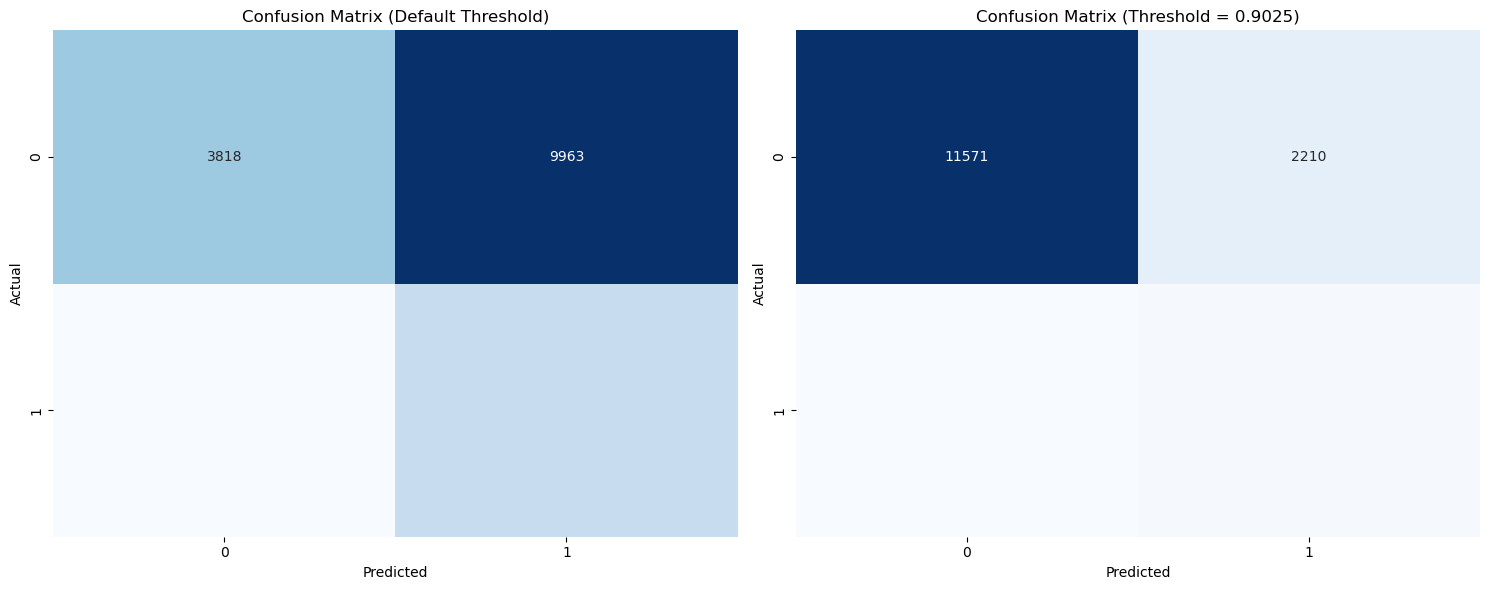

In [32]:
# Generate confusion matrix heatmap
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
cm_default = confusion_matrix(y_test, y_pred_default)
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix (Default Threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.subplot(1, 2, 2)
cm_tuned = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f"Confusion Matrix (Threshold = {best_params['threshold']:.4f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

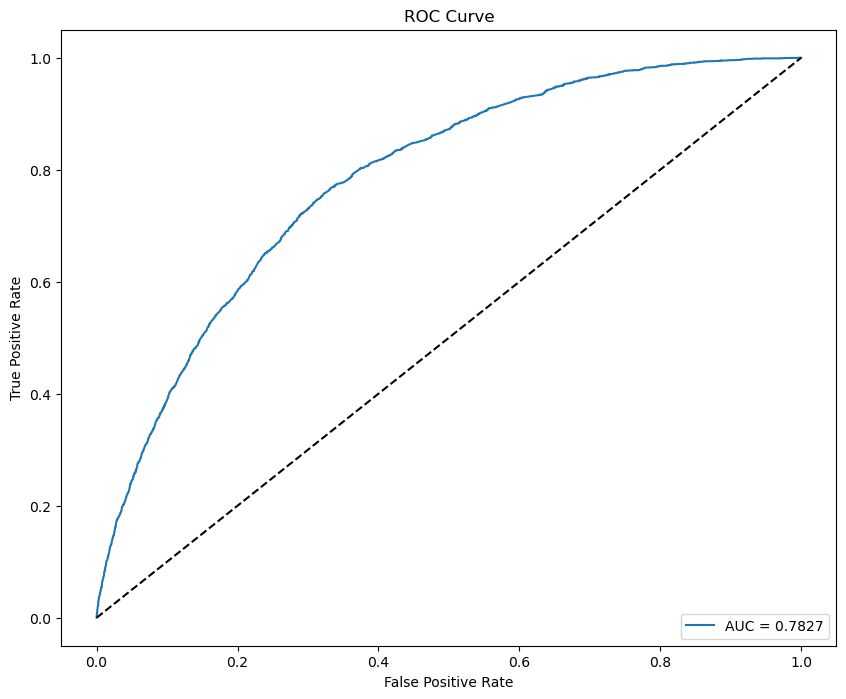

In [33]:
# Plot ROC curve
plt.figure(figsize=(10, 8))
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

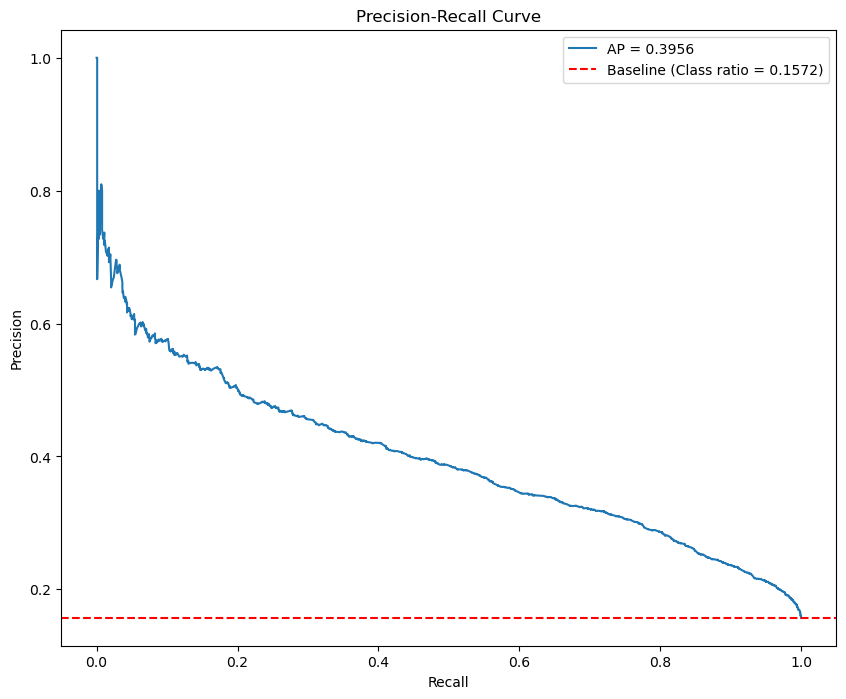

In [34]:
# Plot Precision-Recall curve
plt.figure(figsize=(10, 8))
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, label=f'AP = {average_precision_score(y_test, y_pred_proba):.4f}')
plt.axhline(y=sum(y_test)/len(y_test), color='r', linestyle='--', 
           label=f'Baseline (Class ratio = {sum(y_test)/len(y_test):.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.savefig('precision_recall_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [35]:
# Feature Importance Analysis
print("\n" + "="*50)
print("6. FEATURE IMPORTANCE ANALYSIS")
print("="*50)


6. FEATURE IMPORTANCE ANALYSIS


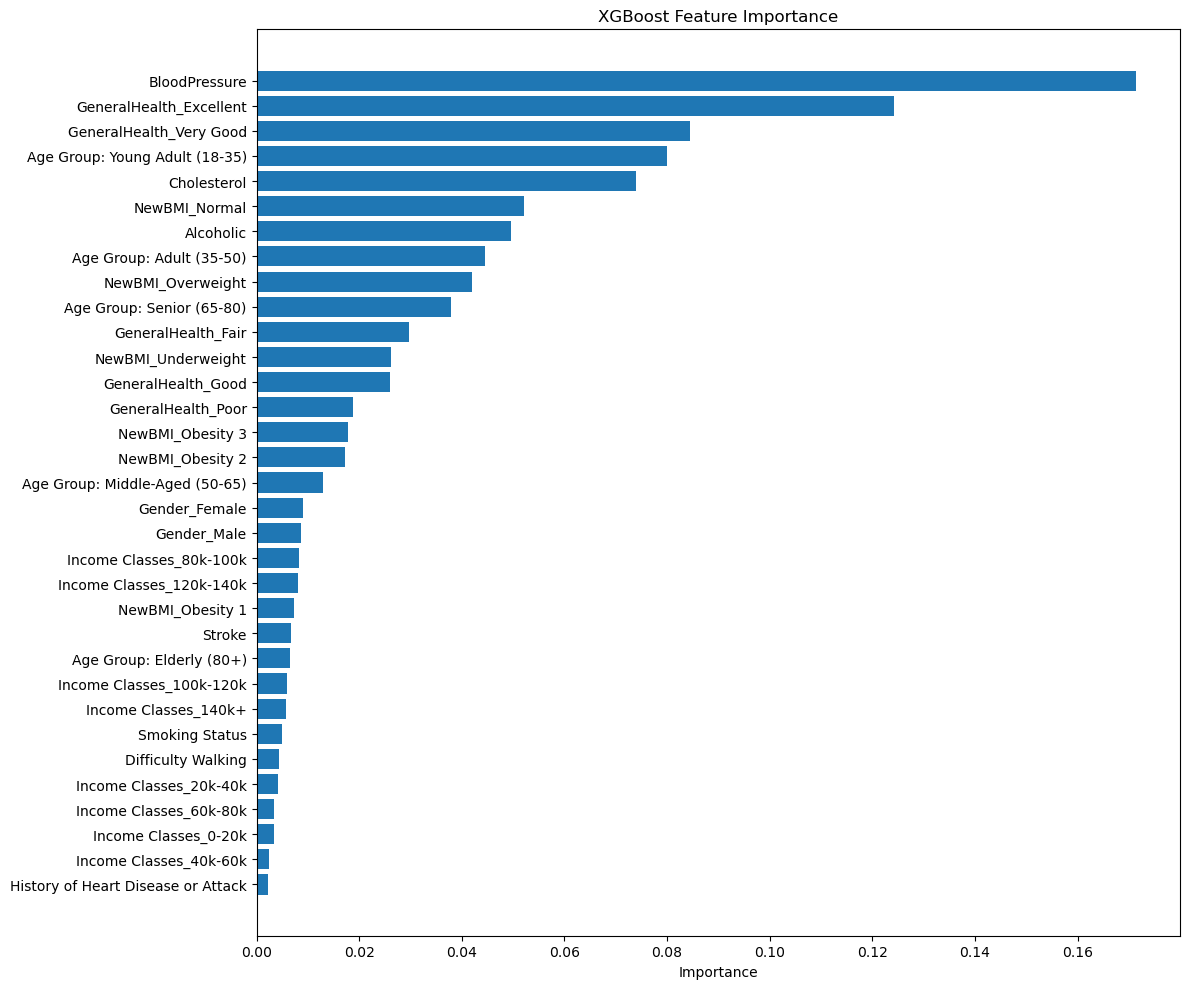

In [36]:
# Plot feature importance if features are available
if hasattr(X_train, 'columns'):
    feature_importance = final_pipeline.named_steps['classifier'].feature_importances_
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(12, 10))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), X_train.columns[sorted_idx])
    plt.title('XGBoost Feature Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.savefig('Feature Importance.png', dpi=300, bbox_inches='tight')
    plt.show()


Generating learning curves...
[learning_curve] Training set sizes: [ 4360 14170 23981 33791 43602]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  7.2min finished


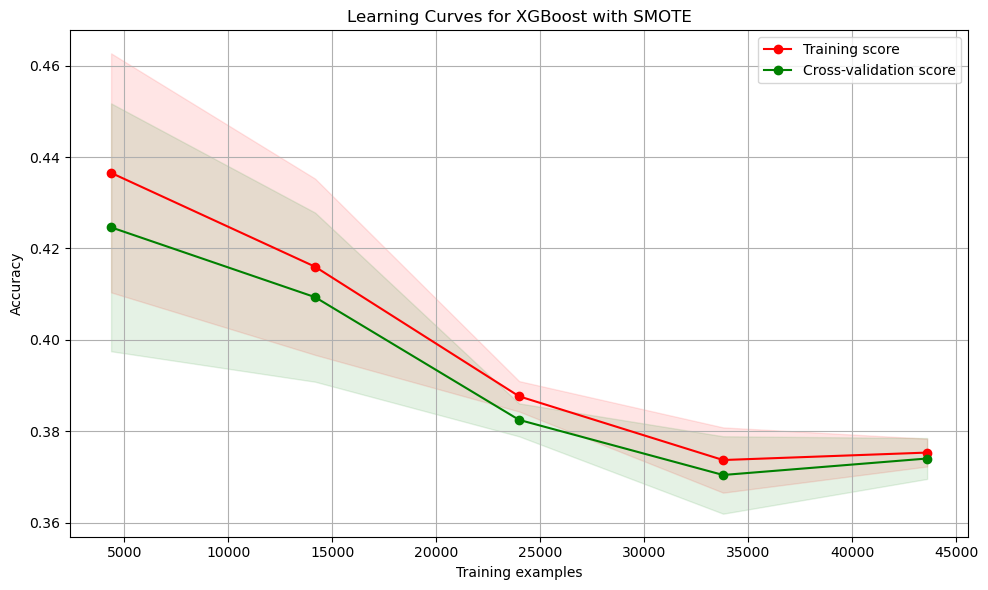

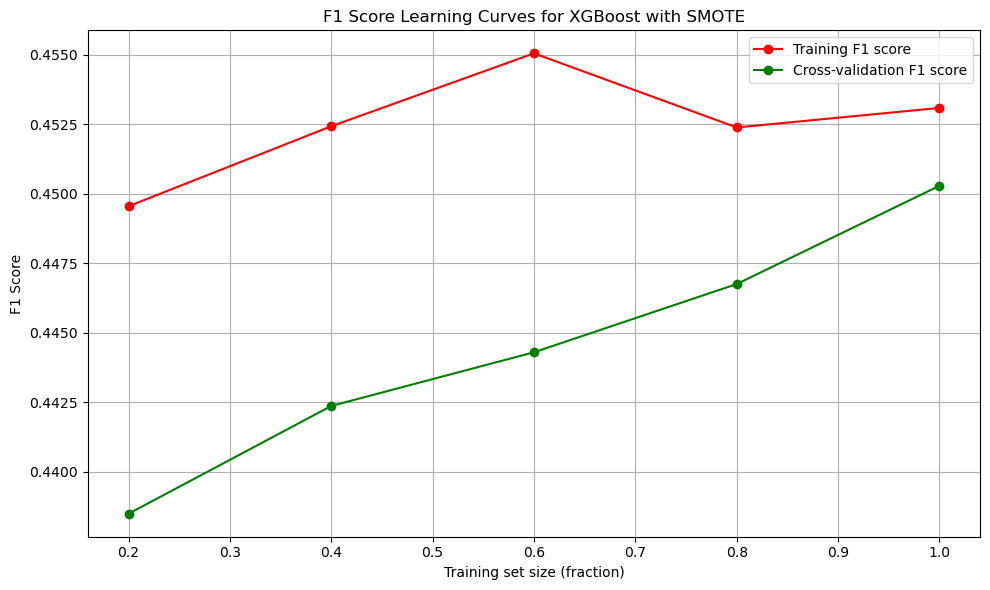


Generating class weight impact visualization...


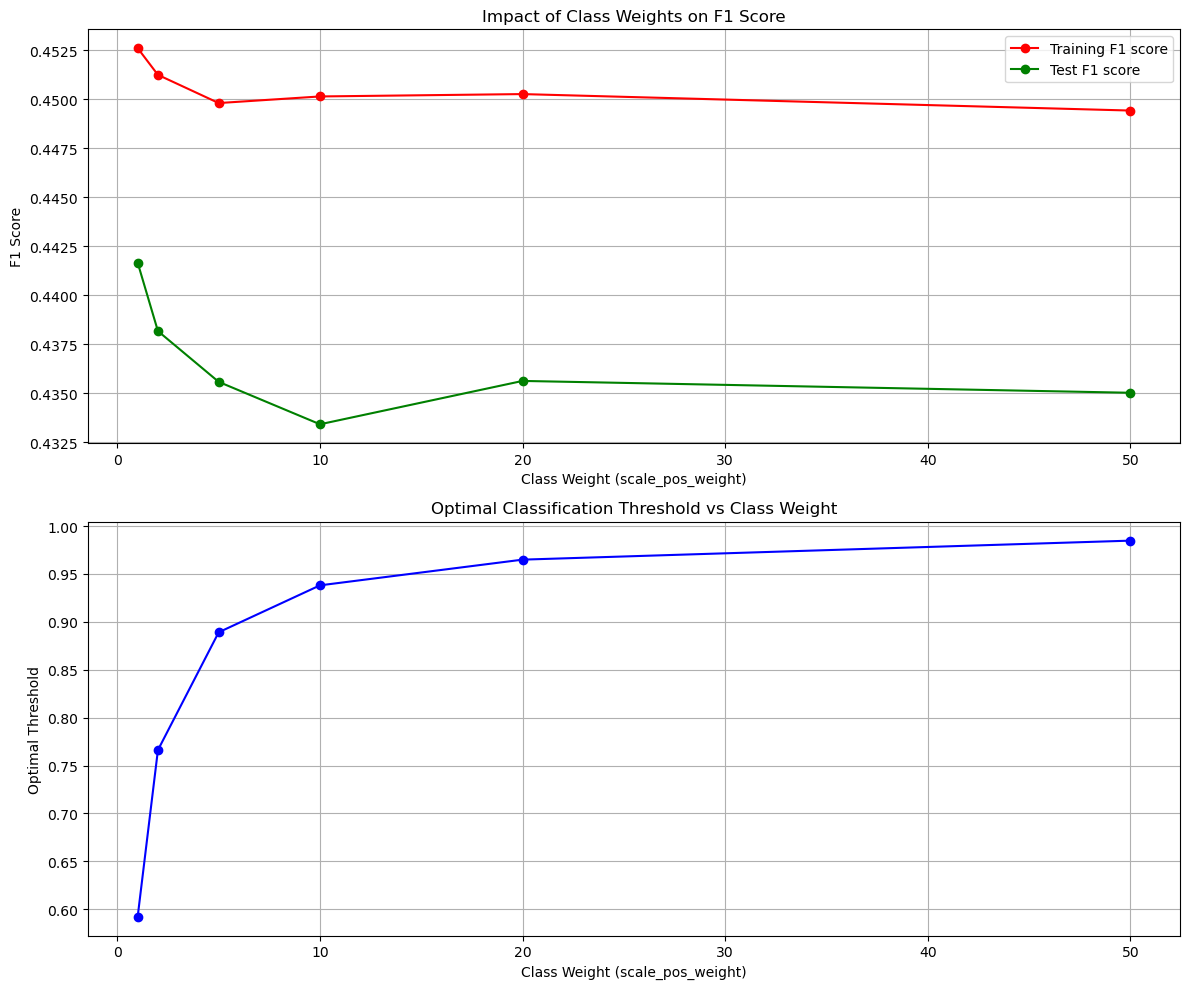

In [37]:
# Plot learning curves
print("\nGenerating learning curves...")

from sklearn.model_selection import learning_curve

# Define a function to calculate f1 score with optimal threshold
def f1_score_with_optimal_threshold(estimator, X, y):
    y_proba = estimator.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y, y_proba)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
    if len(thresholds) > 0:
        optimal_idx = np.argmax(f1_scores[:-1])
        optimal_threshold = thresholds[optimal_idx]
    else:
        optimal_threshold = 0.5
    y_pred = (y_proba >= optimal_threshold).astype(int)
    return f1_score(y, y_pred)

# Create a simpler pipeline for learning curves (to save computation time)
simple_pipeline = ImbPipeline([
    ('sampling', chosen_sampler),
    ('classifier', XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        n_estimators=100,  # Reduced for faster computation
        learning_rate=0.05,
        max_depth=best_params['max_depth'] if 'best_params' in locals() else 4,
        min_child_weight=best_params['min_child_weight'] if 'best_params' in locals() else 5,
        subsample=0.7,
        colsample_bytree=0.7,
        scale_pos_weight=class_weights[1],
        use_label_encoder=False
    ))
])

# Define training sizes
train_sizes = np.linspace(0.1, 1.0, 5)

# Calculate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    simple_pipeline, 
    X_train, 
    y_train,
    train_sizes=train_sizes,
    cv=3,
    scoring='accuracy',  # We'll use accuracy for learning curves
    n_jobs=-1,
    verbose=1
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.grid()
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.title("Learning Curves for XGBoost with SMOTE")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig('Learning Curves for XGBoost with SMOTE.png', dpi=300, bbox_inches='tight')
plt.show()


# For F1 scores, we'll use a manual approach since we need optimal thresholds
f1_train_sizes = np.linspace(0.2, 1.0, 5)  # Use fewer points to save time
f1_train_scores = []
f1_test_scores = []

# Get stratified folds
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_size in f1_train_sizes:
    # Initialize scores for this training size
    size_train_scores = []
    size_test_scores = []
    
    # Create multiple train/test splits for cross-validation
    for train_index, test_index in skf.split(X_train, y_train):
        X_fold_train = X_train[train_index] if isinstance(X_train, np.ndarray) else X_train.iloc[train_index]
        X_fold_test = X_train[test_index] if isinstance(X_train, np.ndarray) else X_train.iloc[test_index]
        y_fold_train = y_train[train_index] if isinstance(y_train, np.ndarray) else y_train.iloc[train_index]
        y_fold_test = y_train[test_index] if isinstance(y_train, np.ndarray) else y_train.iloc[test_index]

        
        # Take subset of training data based on train_size
        if train_size < 1.0:
            # Stratified sampling to maintain class balance
            _, X_subset, _, y_subset = train_test_split(
                X_fold_train, y_fold_train, 
                test_size=train_size, 
                random_state=42, 
                stratify=y_fold_train
            )
        else:
            X_subset, y_subset = X_fold_train, y_fold_train
            
        # Apply sampling only to training subset
        X_subset_resampled, y_subset_resampled = chosen_sampler.fit_resample(X_subset, y_subset)
        
        # Train model on subset
        model = XGBClassifier(
            objective='binary:logistic',
            random_state=42,
            n_estimators=100,
            learning_rate=0.05,
            max_depth=best_params['max_depth'] if 'best_params' in locals() else 4,
            subsample=0.7,
            colsample_bytree=0.7,
            scale_pos_weight=class_weights[1],
            use_label_encoder=False
        )
        
        model.fit(X_subset_resampled, y_subset_resampled)
        
        # Get scores with optimal threshold
        # Training score
        train_proba = model.predict_proba(X_subset)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_subset, train_proba)
        f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
        if len(thresholds) > 0:
            optimal_idx = np.argmax(f1_scores[:-1])
            optimal_threshold = thresholds[optimal_idx]
        else:
            optimal_threshold = 0.5
        train_pred = (train_proba >= optimal_threshold).astype(int)
        train_f1 = f1_score(y_subset, train_pred)
        size_train_scores.append(train_f1)
        
        # Test score
        test_proba = model.predict_proba(X_fold_test)[:, 1]
        test_pred = (test_proba >= optimal_threshold).astype(int)
        test_f1 = f1_score(y_fold_test, test_pred)
        size_test_scores.append(test_f1)
    
    # Append average scores for this training size
    f1_train_scores.append(np.mean(size_train_scores))
    f1_test_scores.append(np.mean(size_test_scores))

# Convert to numpy arrays
f1_train_scores = np.array(f1_train_scores)
f1_test_scores = np.array(f1_test_scores)

# Plot F1 learning curves
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(f1_train_sizes, f1_train_scores, 'o-', color="r", label="Training F1 score")
plt.plot(f1_train_sizes, f1_test_scores, 'o-', color="g", label="Cross-validation F1 score")
plt.xlabel("Training set size (fraction)")
plt.ylabel("F1 Score")
plt.title("F1 Score Learning Curves for XGBoost with SMOTE")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig('F1 Score Learning Curves.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot train vs test score for different class weights
print("\nGenerating class weight impact visualization...")

# Try different weights for the minority class
weight_values = [1, 2, 5, 10, 20, 50]
weight_train_scores = []
weight_test_scores = []
weight_thresholds = []

for weight in weight_values:
    # Create model with specific class weight
    model = XGBClassifier(
        objective='binary:logistic',
        random_state=42,
        n_estimators=100,
        learning_rate=0.05,
        max_depth=best_params['max_depth'] if 'best_params' in locals() else 4,
        subsample=0.7,
        colsample_bytree=0.7,
        scale_pos_weight=weight,  # Vary this parameter
        use_label_encoder=False
    )
    
    # Apply sampling 
    X_resampled, y_resampled = chosen_sampler.fit_resample(X_train_sub, y_train_sub)
    
    # Train model
    model.fit(X_resampled, y_resampled)
    
    # Find optimal threshold on validation set
    val_proba = model.predict_proba(X_val)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, val_proba)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
    if len(thresholds) > 0:
        optimal_idx = np.argmax(f1_scores[:-1])
        optimal_threshold = thresholds[optimal_idx]
    else:
        optimal_threshold = 0.5
    
    # Save threshold
    weight_thresholds.append(optimal_threshold)
    
    # Calculate scores with optimal threshold
    # Training score
    train_proba = model.predict_proba(X_train_sub)[:, 1]
    train_pred = (train_proba >= optimal_threshold).astype(int)
    train_f1 = f1_score(y_train_sub, train_pred)
    weight_train_scores.append(train_f1)
    
    # Test score
    test_proba = model.predict_proba(X_test)[:, 1]
    test_pred = (test_proba >= optimal_threshold).astype(int)
    test_f1 = f1_score(y_test, test_pred)
    weight_test_scores.append(test_f1)

# Plot results
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.plot(weight_values, weight_train_scores, 'o-', color="r", label="Training F1 score")
plt.plot(weight_values, weight_test_scores, 'o-', color="g", label="Test F1 score")
plt.xlabel("Class Weight (scale_pos_weight)")
plt.ylabel("F1 Score")
plt.title("Impact of Class Weights on F1 Score")
plt.legend(loc="best")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(weight_values, weight_thresholds, 'o-', color="b")
plt.xlabel("Class Weight (scale_pos_weight)")
plt.ylabel("Optimal Threshold")
plt.title("Optimal Classification Threshold vs Class Weight")
plt.grid(True)

plt.tight_layout()
plt.savefig('Impact of Class Weights on F1 Score and Optimal Classification Threshold vs Class Weight', dpi=300, bbox_inches='tight')
plt.show()

In [38]:
# ======= 9. SAVE MODEL =======
print("\n" + "="*50)
print("9. SAVE MODEL")
print("="*50)


9. SAVE MODEL


In [39]:
# Plot tuning results
tuning_df = pd.DataFrame(results)
print("\nHyperparameter Tuning Results:")
print(tuning_df.sort_values('f1_score', ascending=False).head())

# Save best model
import joblib
joblib.dump(final_pipeline, 'xgboost_tuned_imbalanced_model.pkl')
print("\nTuned model saved as 'xgboost_tuned_imbalanced_model.pkl'")

# Print final recommendations
print("\nFinal Recommendations:")
print("1. Consider feature engineering based on the feature importance plot")
print("2. Try different class weights or sampling ratios")
print("3. For deployment, use the optimal threshold of {:.4f}".format(best_params['threshold']))
print("4. Consider ensemble methods with this model as one component")
print("5. For even better results, collect more data for the minority class")
print(f"6. Monitor model performance over time, especially the F1 score of {best_score:.4f}")


Hyperparameter Tuning Results:
    max_depth  min_child_weight  subsample  colsample_bytree  gamma  f1_score  \
2           3                 3        0.8               0.7    0.1  0.470997   
3           3                 3        0.8               0.7    0.2  0.470997   
6           3                 5        0.8               0.7    0.1  0.470852   
7           3                 5        0.8               0.7    0.2  0.470852   
14          4                 5        0.8               0.7    0.1  0.470819   

    threshold  iterations  
2    0.902486         143  
3    0.902486         143  
6    0.902725         145  
7    0.902725         145  
14   0.895828          93  

Tuned model saved as 'xgboost_tuned_imbalanced_model.pkl'

Final Recommendations:
1. Consider feature engineering based on the feature importance plot
2. Try different class weights or sampling ratios
3. For deployment, use the optimal threshold of 0.9025
4. Consider ensemble methods with this model as one comp

In [1]:
'''Algorithm: XGBoost for Binary Classification
Input: Training data (X, y), validation data (X_val, y_val), hyperparameters
Output: Ensemble of decision trees

1. Initialize model with constant values:
   F_0(x) = 0

2. For m = 1 to M (number of boosting rounds):
   a. Compute negative gradients (residuals) for each instance:
      r_i = -[∂L(y_i, F_{m-1}(x_i))/∂F_{m-1}(x_i)]
   
   b. Fit a regression tree h_m(x) to the negative gradients
      - Apply split finding algorithm with regularization
      - Maximize gain = (gradient_sum_left²/hessian_sum_left + gradient_sum_right²/hessian_sum_right - gradient_sum²/hessian_sum) / 2 - γ
   
   c. For each leaf j in the tree, compute optimal weight:
      w_j = -sum(gradient)/sum(hessian + λ)
   
   d. Update the model:
      F_m(x) = F_{m-1}(x) + η * h_m(x)
      where η is the learning rate
   
   e. Evaluate model on validation data
      If early_stopping_rounds is specified and no improvement for specified rounds, stop

3. Return final model F_M(x)'''

'Algorithm: XGBoost for Binary Classification\nInput: Training data (X, y), validation data (X_val, y_val), hyperparameters\nOutput: Ensemble of decision trees\n\n1. Initialize model with constant values:\n   F_0(x) = 0\n\n2. For m = 1 to M (number of boosting rounds):\n   a. Compute negative gradients (residuals) for each instance:\n      r_i = -[∂L(y_i, F_{m-1}(x_i))/∂F_{m-1}(x_i)]\n   \n   b. Fit a regression tree h_m(x) to the negative gradients\n      - Apply split finding algorithm with regularization\n      - Maximize gain = (gradient_sum_left²/hessian_sum_left + gradient_sum_right²/hessian_sum_right - gradient_sum²/hessian_sum) / 2 - γ\n   \n   c. For each leaf j in the tree, compute optimal weight:\n      w_j = -sum(gradient)/sum(hessian + λ)\n   \n   d. Update the model:\n      F_m(x) = F_{m-1}(x) + η * h_m(x)\n      where η is the learning rate\n   \n   e. Evaluate model on validation data\n      If early_stopping_rounds is specified and no improvement for specified rounds, 

In [3]:
'''[Initialize Dataset] → [Split into Train/Test]
       ↓
[Apply SMOTE to balance training data]
       ↓
[Initialize XGBoost Model with class weights]
       ↓
[For each boosting round:]
       ↓
   [Compute gradients/residuals]
       ↓
   [Build new tree to fit residuals]
       ↓
   [Apply regularization to prevent overfitting]
       ↓
   [Add tree to ensemble with learning rate]
       ↓
   [Check early stopping criteria on validation data]
       ↓
[Find optimal prediction threshold via F1 optimization]
       ↓
[Evaluate final model with metrics for imbalanced data]'''

'[Initialize Dataset] → [Split into Train/Test]\n       ↓\n[Apply SMOTE to balance training data]\n       ↓\n[Initialize XGBoost Model with class weights]\n       ↓\n[For each boosting round:]\n       ↓\n   [Compute gradients/residuals]\n       ↓\n   [Build new tree to fit residuals]\n       ↓\n   [Apply regularization to prevent overfitting]\n       ↓\n   [Add tree to ensemble with learning rate]\n       ↓\n   [Check early stopping criteria on validation data]\n       ↓\n[Find optimal prediction threshold via F1 optimization]\n       ↓\n[Evaluate final model with metrics for imbalanced data]'

# END of akur0860- XGBoost

In [5]:
!pip install pandas scikit-learn matplotlib seaborn

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [9]:
# Load your dataset
df = pd.read_csv("cleaned_diabetes_data.csv")

In [11]:
# Convert 'Diabetes Status' column to binary (0 for 'No', 1 for 'Diabetes' and 'Prediabetes')
df['Diabetes Status'] = df['Diabetes Status'].replace({'No': 0, 'Diabetes': 1, 'Prediabetes': 1})

# Verify the change
print(df['Diabetes Status'].unique())

[0 1]


In [13]:
# Remove rows where 'Gender' is 'Not specified'
df = df[df['Gender'] != 'Not specified']

# Check the shape of the cleaned dataset
print("Cleaned Dataset Shape:", df.shape)

df = pd.get_dummies(df, columns=['Gender', 'Income Classes'], drop_first=False)

# Convert all boolean columns to integers (0/1)
df = df.astype({col: 'int' for col in df.select_dtypes('bool').columns})

# Remove redundant original categorical columns (keep one-hot encoded versions)
cols_to_drop = [
    'BMI Classes',
    'Body Mass Index (BMI)',
    'Age Group Classes',
    'General Health Classes',
    'Income',
    'Education Level',
    'Days with Physical Health Issues',
    'Days with Mental Health Issues',
    'Age Group: Child (0-12)',#As only 0 is present in these 2 columns
    'Age Group: Teen (12-18)',
    'Cholesterol Check',
]

df = df.drop(cols_to_drop, axis=1)

# Convert all columns with 0 and 1 values to integers
cols_to_convert = df.select_dtypes(include=['float64']).columns

# Convert to int
df[cols_to_convert] = df[cols_to_convert].astype('int')

# Verify the change
print(df.dtypes)

# Get unique values for each column
unique_values = {col: df[col].unique().tolist() for col in df.columns}

# Print the unique values
for column, values in unique_values.items():
    print(f"Unique values in '{column}':")
    print(values)
    print('-' * 50)

# Keep either continuous variables OR one-hot encoded versions (choose one):
df = df.drop(['Age'], axis=1)  # Keep one-hot age groups


from sklearn.model_selection import train_test_split

X = df.drop("Diabetes Status", axis=1)
y = df["Diabetes Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Cleaned Dataset Shape: (81756, 38)
Smoking Status                        int32
Stroke                                int32
History of Heart Disease or Attack    int32
Difficulty Walking                    int32
Age                                   int32
BloodPressure                         int64
Cholesterol                           int64
Alcoholic                             int64
NewBMI_Underweight                    int64
NewBMI_Normal                         int64
NewBMI_Overweight                     int64
NewBMI_Obesity 1                      int64
NewBMI_Obesity 2                      int64
NewBMI_Obesity 3                      int64
GeneralHealth_Poor                    int64
GeneralHealth_Fair                    int64
GeneralHealth_Good                    int64
GeneralHealth_Very Good               int64
GeneralHealth_Excellent               int64
Age Group: Young Adult (18-35)        int64
Age Group: Adult (35-50)              int64
Age Group: Middle-Aged (50-65)        int

# ysab0639- SVM

In [15]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

# Check new class distribution
print("Resampled class distribution:", Counter(y_train))

Resampled class distribution: Counter({0: 55139, 1: 55139})


In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [19]:
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train)


SVC(random_state=42)

In [20]:
y_pred = svm_model.predict(X_test_scaled)
svm_preds = svm_model.predict(X_test_scaled)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=1))


Accuracy Score: 0.7134907045009785

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.72      0.81     13764
           1       0.31      0.66      0.42      2588

    accuracy                           0.71     16352
   macro avg       0.61      0.69      0.62     16352
weighted avg       0.82      0.71      0.75     16352


Confusion Matrix:
 [[9965 3799]
 [ 886 1702]]
              precision    recall  f1-score   support

           0       0.92      0.72      0.81     13764
           1       0.31      0.66      0.42      2588

    accuracy                           0.71     16352
   macro avg       0.61      0.69      0.62     16352
weighted avg       0.82      0.71      0.75     16352



In [21]:
print(y.value_counts())

Diabetes Status
0    68903
1    12853
Name: count, dtype: int64


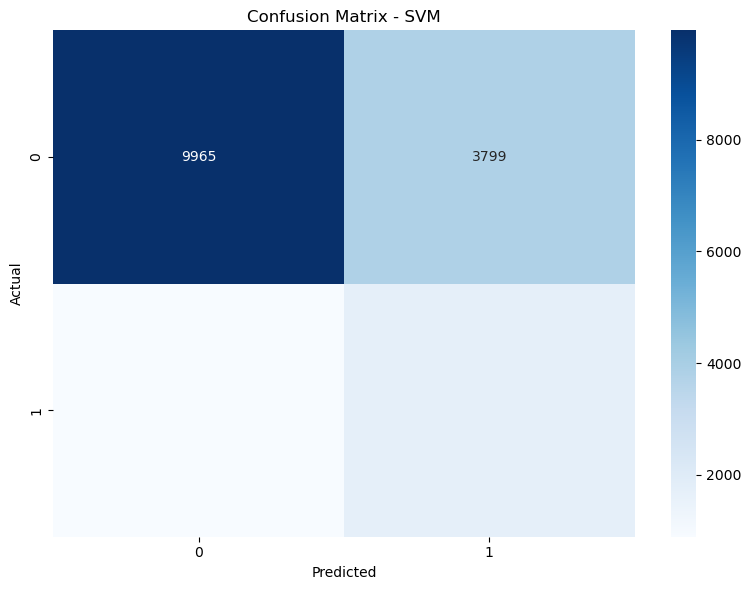

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Define class labels from the actual target values
classes_ = sorted(y_test.unique())

# Create the confusion matrix
cm = confusion_matrix(y_test, svm_preds)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes_, yticklabels=classes_)
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


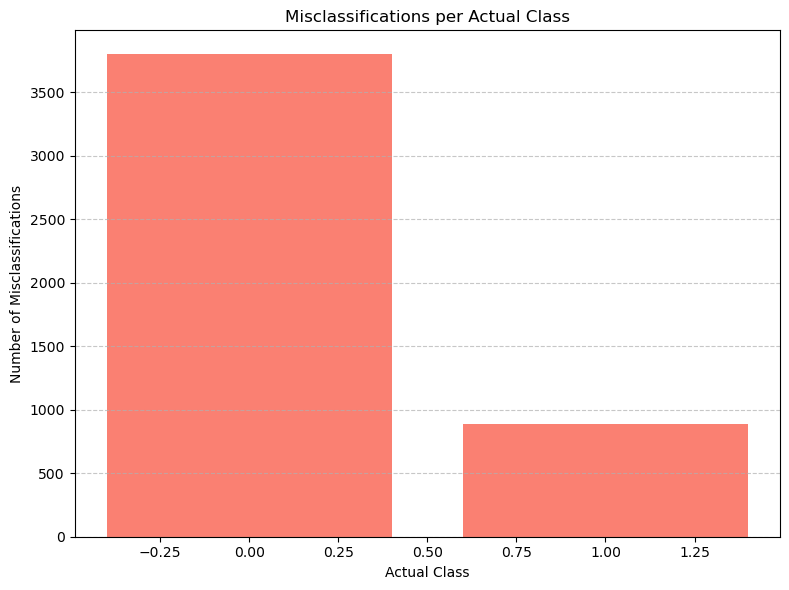

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# First, ensure svm_preds and y_test are defined
# Create a comparison DataFrame
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': svm_preds})

# Identify misclassified rows
errors_df = comparison_df[comparison_df['Actual'] != comparison_df['Predicted']]

# Count misclassifications per actual class
error_counts = errors_df['Actual'].value_counts().sort_index()

# Use the class labels directly (no inverse_transform needed)
error_labels = error_counts.index

# Plot
plt.figure(figsize=(8, 6))
plt.bar(error_labels, error_counts.values, color='salmon')
plt.title("Misclassifications per Actual Class")
plt.xlabel("Actual Class")
plt.ylabel("Number of Misclassifications")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


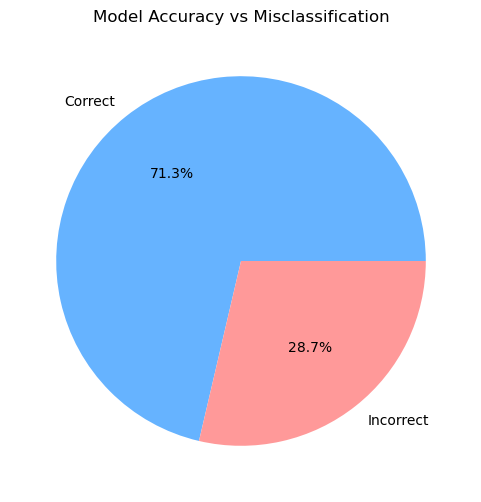

In [33]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, svm_preds)
error = 1 - accuracy

plt.figure(figsize=(6, 6))
plt.pie([accuracy, error], labels=["Correct", "Incorrect"], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
plt.title("Model Accuracy vs Misclassification")
plt.show()


In [35]:
from sklearn.metrics import classification_report

print("Classification Report:\n")
print(classification_report(y_test, svm_preds))


Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.72      0.81     13764
           1       0.31      0.66      0.42      2588

    accuracy                           0.71     16352
   macro avg       0.61      0.69      0.62     16352
weighted avg       0.82      0.71      0.75     16352



In [37]:
from sklearn.inspection import permutation_importance

result = permutation_importance(svm_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Map importance to feature names
perm_importance = pd.Series(result.importances_mean, index=X.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
perm_importance.plot(kind='bar', color='coral')
plt.title("Permutation Feature Importance (SVM)")
plt.ylabel("Mean Decrease in Accuracy")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


KeyboardInterrupt



In [ ]:
from sklearn.svm import LinearSVC
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Train a linear SVM
linear_svm = LinearSVC(class_weight='balanced', max_iter=10000, random_state=42)
linear_svm.fit(X_train_scaled, y_train)

# Get feature importance (absolute value of coefficients)5
importance = np.abs(linear_svm.coef_).mean(axis=0)  # for multi-class (OvR), take mean across classes

# Map back to feature names
feature_importance = pd.Series(importance, index=X.columns).sort_values(ascending=False)

# Plot top features
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar', color='teal')
plt.title("Feature Importance (Linear SVM)")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# End of ysab0639- SVM

# Group Component 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

r2_scores = {'XGBoost': 0.79, 'SVM': 0.6516}
rmse_scores = {'XGBoost': 3016.4078, 'SVM': 5192.6852}

models = list(r2_scores.keys())
r2_values = list(r2_scores.values())
rmse_values = list(rmse_scores.values())

x = np.arange(len(models))  # label locations
width = 0.35  # bar width

fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.bar(x - width/2, r2_values, width, label='R² Score', color='skyblue')
ax1.bar(x + width/2, rmse_values, width, label='RMSE', color='lightcoral')
ax1.set_ylabel('Scores')
ax1.set_title('Model Performance Comparison: XGBoost vs SVM')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()